# Final Project
Group 4: Joshua Hummell, Jiho Kim, Scott Reed

Elon Musk recently decided to purchase Twitter. After considering other final projects, we decided to do a combined Network and Text analysis on Elons Musk’s tweets for directly after announcing he was going to buy Twitter. In this way, we can see the networks that support Elon or disapprove of Elon.

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite as bi
import pandas as pd
import numpy as np
import scipy
import random
import re

In [2]:
import sys
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
import nltk
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from langdetect import detect
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer

pd.set_option('display.max_columns', None)

## Step One: getting the tweets 
We have it in Markdown now becuase we already ran it. So for consistency, we ran it once and it was too large to be hosted on Github so we had to store it on my personal website, as you will see in Step 2

In [3]:
import nest_asyncio
nest_asyncio.apply()
import twint

In [4]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context
df = pd.read_table("https://hummelljoshua.me/elon-tweets.csv",
                encoding='utf-8', 
                
                sep = ",", 
                usecols = ['username','date','time', 'tweet', 'likes_count', 'replies_count','retweets_count'])

In [5]:
df.head()

,date,time,username,tweet,replies_count,retweets_count,likes_count
0,2022-04-22,14:37:08,fariha173_,@Moon50097307 @WhaleChart @Marvin_Inu @elonmus...,0,0,0
1,2022-04-22,14:37:07,boonefollow187,#PMSUpToSomethingSZN @PatMcAfeeShow is teaming...,0,0,0
2,2022-04-22,14:37:07,utopia_hippie,@Feelthe86085074 @AtNecks @ShaunKraisman @Gabr...,0,0,0
3,2022-04-22,14:37:07,fleecegeek,High 👋 @elonmusk ... only you buying Twitter c...,0,0,0
4,2022-04-22,14:37:07,letsunitegld,@vico_dbn 👍🏿and Elon musk is the African of Am...,0,0,0


In [6]:
df.describe()

,replies_count,retweets_count,likes_count
count,365235.000000,365235.000000,365235.000000
mean,2.527827,4.015894,40.609104
std,180.866993,261.118664,2976.677625
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,1.000000
max,63334.000000,65412.000000,714555.000000


(array([547.,  12.,   5.,   8.,   4.,   2.,   1.,   0.,   1.,   2.]),
 array([  1005.,  72360., 143715., 215070., 286425., 357780., 429135.,
        500490., 571845., 643200., 714555.]),
 <BarContainer object of 10 artists>)

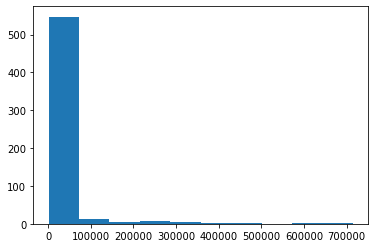

In [7]:
plt.hist(df['likes_count'].loc[df['likes_count'] > 1000], bins=10)

(array([348988.,   7408.,   2427.,   1230.,    808.]),
 array([0. , 1.8, 3.6, 5.4, 7.2, 9. ]),
 <BarContainer object of 5 artists>)

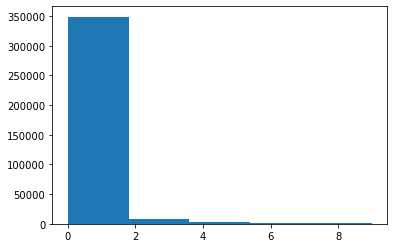

In [8]:
plt.hist(df['retweets_count'].loc[df['retweets_count'] < 10], bins=5)

(array([135.,  12.,   2.,   3.,   2.]),
 array([ 1003. , 13884.8, 26766.6, 39648.4, 52530.2, 65412. ]),
 <BarContainer object of 5 artists>)

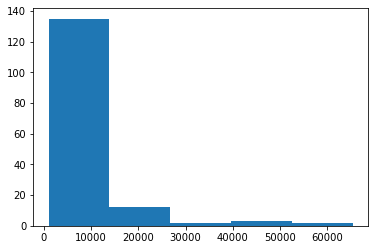

In [9]:
plt.hist(df['retweets_count'].loc[df['retweets_count'] > 1000], bins=5)

In [10]:
print("There are", len(df['retweets_count'].loc[df['retweets_count'] < 100]), "people who got less than 100 retweets")
print("There are", len(df['retweets_count'].loc[df['retweets_count'] > 100]), "people who got more than 100 retweets and", len(df['retweets_count'].loc[df['retweets_count'] > 1000]), "who got more than 1000")

There are 364431 people who got less than 100 retweets
There are 784 people who got more than 100 retweets and 154 who got more than 1000


In [11]:
print("There are", len(df['replies_count'].loc[df['replies_count'] < 100]), "people who got less than 100 replies")
print("There are", len(df['replies_count'].loc[df['replies_count'] > 100]), "people who got more than 100 replies and", len(df['replies_count'].loc[df['replies_count'] > 1000]), "who got more than 1000")

There are 364711 people who got less than 100 replies
There are 521 people who got more than 100 replies and 109 who got more than 1000


## Step 3: Sentiment Analysis
In order to run the Sentiment analysis we are going to create new dataframe from the one above that classifies each tweet on % of neutralilty, positivity, and negativity, and based on the % we will classify it as one of them. 

In [13]:
positive = int(0)
negative = int(0)
neutral = int(0)
polarity = int(0)
tweet_list = []
neutral_list = []
negative_list = []
positive_list = []
def percentage(part,whole):
    return 100 * float(part)/float(whole)
noOfTweet = len(df['tweet'])
for tweet in df['tweet']:
    
    tweet_list.append(tweet)
    analysis = TextBlob(tweet)
    score = SentimentIntensityAnalyzer().polarity_scores(tweet)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    
    polarity += analysis.sentiment.polarity

    if neg > pos:
        negative_list.append(tweet)
        negative += 1
    elif pos > neg:
        positive_list.append(tweet)
        positive += 1

    elif pos == neg:
        neutral_list.append(tweet)
        neutral += 1
        
df_n = pd.DataFrame(negative_list, columns =['tweet'])
df_n['cat'] = "Neg"
df_p = pd.DataFrame(positive_list, columns =['tweet'])
df_p['cat'] = "Pos"
df_ne = pd.DataFrame(neutral_list, columns =['tweet'])
df_ne['cat'] = "Neu"

df_n = df_n.append([df_p, df_ne], ignore_index=True, sort=False)

KeyboardInterrupt: 

The below code has been turned into markdown becuase it is machine heavy to run. So I took the liberty of running it on my own and saving the file, where it was just downloaded above. 

In [14]:
df_f = pd.read_table("https://hummelljoshua.me/sentiment.tsv",
                header=0, 
                sep = "\t")

df_f = df.merge(df_n[['cat','tweet']], how='left', on='tweet')

df_f['text'] = df_f['tweet']

remove_rt = lambda x: re.sub('RT'," ",x)
rt = lambda x: re.sub("((@)\w*(?=\s))"," ",x)
hasht = lambda x: re.sub("((#)\w*(?=\s))"," ",x)
dolla =  lambda x: re.sub("((\$)\w*(?=\s))"," ",x)
df_f["text"] = df_f.text.map(remove_rt).map(rt).map(hasht).map(dolla)
df_f["text"] = df_f.text.str.lower()
df_f.head(10)

df_f[['polarity', 'subjectivity']] = df_f['text'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))


#Calculating Negative, Positive, Neutral and Compound values
import time
n = len(df_f)

t0 = time.time()

for index, row in df_f['text'].iteritems():
    t1 = time.time()
    print("Processing file {} ({}%)".format(index, 100*index//n), end="")
    
    score = SentimentIntensityAnalyzer().polarity_scores(row)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    
    if neg > pos:
        df_f.loc[index, 'sentiment'] = "negative"
    elif pos > neg:
        df_f.loc[index, 'sentiment'] = "positive"
    else:
        df_f.loc[index, 'sentiment'] = "neutral"
        
    df_f.loc[index, 'neg'] = neg
    df_f.loc[index, 'neu'] = neu
    df_f.loc[index, 'pos'] = pos
    df_f.loc[index, 'compound'] = comp
    t2 = time.time()
    print(" {}s (total: {}s)".format(round(t2-t1, 2), round(t2-t0,2)))


In [29]:
df_f.head(30)

,Unnamed: 0,date,time,username,tweet,replies_count,retweets_count,likes_count,cat,text,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,0,2022-04-22,14:37:08,fariha173_,@Moon50097307 @WhaleChart @Marvin_Inu @elonmus...,0,0,0,Neu,going up to wards moon 🌖..,0.000000,0.000000,neutral,0.000,1.000,0.000,0.0000
1,1,2022-04-22,14:37:07,boonefollow187,#PMSUpToSomethingSZN @PatMcAfeeShow is teaming...,0,0,0,Neu,is teaming up with elon musk and buying ou...,0.000000,0.000000,neutral,0.000,1.000,0.000,0.0000
2,2,2022-04-22,14:37:07,utopia_hippie,@Feelthe86085074 @AtNecks @ShaunKraisman @Gabr...,0,0,0,Pos,it takes all kinds to change the wor...,0.500000,0.500000,positive,0.000,0.861,0.139,0.4404
3,3,2022-04-22,14:37:07,fleecegeek,High 👋 @elonmusk ... only you buying Twitter c...,0,0,0,Pos,high 👋 ... only you buying twitter could dra...,0.347857,0.558690,positive,0.138,0.673,0.189,0.3612
4,4,2022-04-22,14:37:07,fleecegeek,High 👋 @elonmusk ... only you buying Twitter c...,0,0,0,Pos,high 👋 ... only you buying twitter could dra...,0.347857,0.558690,positive,0.138,0.673,0.189,0.3612
5,5,2022-04-22,14:37:07,fleecegeek,High 👋 @elonmusk ... only you buying Twitter c...,0,0,0,Pos,high 👋 ... only you buying twitter could dra...,0.347857,0.558690,positive,0.138,0.673,0.189,0.3612
6,6,2022-04-22,14:37:07,letsunitegld,@vico_dbn 👍🏿and Elon musk is the African of Am...,0,0,0,Neu,👍🏿and elon musk is the african of america😉,0.000000,0.000000,neutral,0.000,1.000,0.000,0.0000
7,7,2022-04-22,14:37:06,fraktalkrypto,🤣🤣 and @elonmusk,0,0,0,Neu,🤣🤣 and @elonmusk,0.000000,0.000000,neutral,0.000,1.000,0.000,0.0000
8,8,2022-04-22,14:37:05,bahhtee0707,@elonmusk elon answer plz who will fly to mars...,0,0,0,Pos,elon answer plz who will fly to mars? human ...,0.400000,0.500000,positive,0.000,0.816,0.184,0.3094
9,9,2022-04-22,14:37:04,nicolaskwon_tor,"On March 14, Elon Musk purchased a 9.2 per cen...",0,0,0,Neu,"on march 14, elon musk purchased a 9.2 per cen...",0.500000,0.500000,neutral,0.000,1.000,0.000,0.0000


Looking at the analysis we see some issues with sentiment analysis and memes, and use of emojis. For the most part this falls out as neutral, but does suggest an area of future work. 

In [16]:
tw_list_negative = df_f[df_f["sentiment"]=="negative"]
tw_list_positive = df_f[df_f["sentiment"]=="positive"]
tw_list_neutral = df_f[df_f["sentiment"]=="neutral"]

In [17]:
def count_values_in_column(data,feature):
    total=data.loc[:,feature].value_counts(dropna=False)
    percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
    return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])

#Count_values for sentiment
count_values_in_column(df_f,"sentiment")

,Total,Percentage
neutral,337049,52.33
positive,187543,29.12
negative,119437,18.55


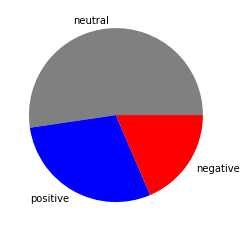

In [18]:
# create data for Pie Chart
pichart = count_values_in_column(df_f,"sentiment")

mylabels = ['neutral', 'positive', 'negative']
mycolors = ["gray", "blue", "red"]
 
plt.pie(pichart['Percentage'], labels = mylabels, colors = mycolors)
plt.show() 

def create_wordcloud(text):
    #mask = np.array(Image.open("cloud.png"))
    stopwords = set(STOPWORDS)
    wc = WordCloud(background_color="black",
    #mask = mask,
    max_words=1000,
    stopwords=stopwords,
    repeat=True)
    wc.generate(str(text))
    wc.to_file("wc.png")
    print("Word Cloud Saved Successfully")
    path="wc.png"
    display(Image.open(path))

Word Cloud Saved Successfully


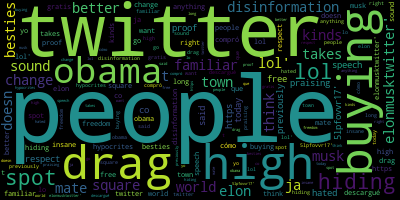

In [22]:
create_wordcloud(tw_list_positive["text"].values)

Word Cloud Saved Successfully


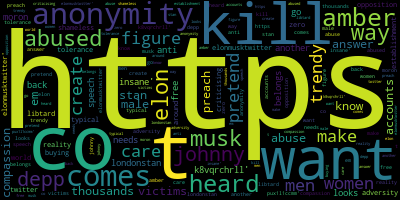

In [23]:
create_wordcloud(tw_list_negative["text"].values)

How concerned are people with Elon taking over Twitter?

We can see that 52% of people do not care, 29% are happy, and 18% are alarmed. However, since the tweets gathered were from the intial days of Elon's announcement, people thought he might be joking, or just spreading rumors as he normally does. Now that he is getting it, it would be interesting to see if sentiments change. 

## Step 4: Network Analysis

This section we will look at the networks surrounding the Positive and Negative Sentiment to see how the sentiment is distributed. 

In [67]:
# create a networkx directed graph
G_retweet = nx.DiGraph()
G_mention = nx.DiGraph()
for r in df_f.iterrows():
    author = r[1]['username']
    author = f'@{author}'
  
    text = r[1]['tweet']
  
    try:
        timestamp = pd.to_datetime(r[1]['date'] +' ' +r[1]['time'])
    except:
        continue
        
    #cat = r[1]['cat']
 
    # use regular expressions to extract retweets and mentions
    retweets = set(re.findall(r"RT @(\w+)", text))
    mentions = set(re.findall(r"@(\w+)", text))
    
    

    # remove duplicated users
    for retweet in retweets:
        if retweet in mentions:
            mentions.remove(retweet)

    # add the users if there are any mentioned in the text.
    has_users = len(retweets) + len(mentions) > 0
    if has_users:
        for u in retweets:
            u = f'@{u}'
            G_retweet.add_edge(author, u, weight=r[1].compound *100 or 0, Timestamp=timestamp)

        for u in mentions:
            u = f'@{u}'
            G_mention.add_edge(author, u, weight=r[1].compound *100 or 0, Timestamp=timestamp)
author = df['username'][0]
author = f'@{author}'
  
text = df['tweet'][0]

timestamp = pd.to_datetime(df['date'] +' ' +  df['time'])
retweets = set(re.findall(r"RT @(\w+)", text))
mentions = set(re.findall(r"@(\w+)", text))


print(author, retweets,mentions)
print(len(retweets))

@fariha173_ set() {'elonmusk', 'WhaleChart', 'Marvin_Inu', 'Moon50097307'}
0


In [25]:
df['username'][0]

'fariha173_'

In [57]:
df_retweet = nx.to_pandas_edgelist(G_retweet)

 
df_mention = nx.to_pandas_edgelist(G_mention)


### Negative and Positive 

In [128]:
def trim_edges(g, weight=1):
    g2=nx.Graph()  
    my_list=[]
    my_list1=[]
    for f, to, edata in g.edges(data=True): 
        if edata['weight'] > weight:
            my_list.append(f)
            my_list1.append(to)
            g2.add_edge(f,to,attr_dict={weight:edata['weight']})
    g2.add_nodes_from(my_list, bipartite=0)
    g2.add_nodes_from(my_list1, bipartite=1)
    return g2

def island_method(g, iterations=5, weight=10):
    weights = [edata['weight'] for f, to, edata in g.edges(data=True)]
    mn=int(min(weights)) if int(min(weights)) > weight else weight
    mx=int(max(weights))
    #compute the size of the step, so we get a reasonable step in iterations
    step=int((mx-mn)/(iterations-1))
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]

In [116]:
islands = island_method(G_mention, 5,20)
for i in islands:
    threshold = i[0]
    graph_size = len(i[1])
    connected_comp = len(list(G_mention.subgraph(c) for c in nx.connected_components(i[1])))
    print("Weight: " + str(threshold), "Nodes: " + str(graph_size), "Subgraphs: " + str(connected_comp))

Weight: 20 Nodes: 93546 Subgraphs: 2561
Weight: 39 Nodes: 73493 Subgraphs: 2202
Weight: 58 Nodes: 44384 Subgraphs: 1628
Weight: 77 Nodes: 18604 Subgraphs: 949
Weight: 96 Nodes: 496 Subgraphs: 54


In [129]:
islands = island_method(G_retweet, 5,20)
for i in islands:
    threshold = i[0]
    graph_size = len(i[1])
    connected_comp = len(list(G_retweet.subgraph(c) for c in nx.connected_components(i[1])))
    print("Weight: " + str(threshold), "Nodes: " + str(graph_size), "Subgraphs: " + str(connected_comp))

Weight: 20 Nodes: 115 Subgraphs: 42
Weight: 38 Nodes: 90 Subgraphs: 35
Weight: 56 Nodes: 55 Subgraphs: 22
Weight: 74 Nodes: 19 Subgraphs: 8
Weight: 92 Nodes: 4 Subgraphs: 2


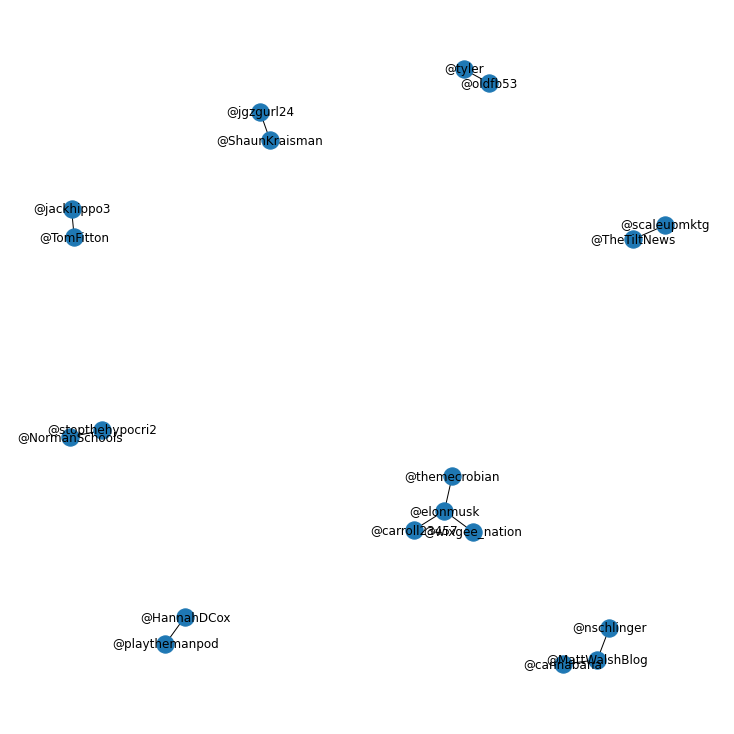

In [130]:
G1=islands[3][1]

plt.figure(figsize=(10,10))
#colors = ["green" if i[weight] > 0  else "red" for i in G_retweet.nodes ]
pos = nx.spring_layout(G1, seed=648)  # Seed layout for reproducible node positions
nx.draw(G1, pos, with_labels=True) #node_color=colors)
plt.show()

In [131]:
def trim_edges(g, weight=1):
    g2=nx.Graph()  
    my_list=[]
    my_list1=[]
    for f, to, edata in g.edges(data=True): 
        if -1*edata['weight'] > weight:
            my_list.append(f)
            my_list1.append(to)
            g2.add_edge(f,to,attr_dict={weight:edata['weight']})
    g2.add_nodes_from(my_list, bipartite=0)
    g2.add_nodes_from(my_list1, bipartite=1)
    return g2

def island_method(g, iterations=5, weight=10):
    weights = [-1*edata['weight'] for f, to, edata in g.edges(data=True)]
    mn=int(min(weights)) if int(min(weights)) > weight else weight
    mx=int(max(weights))
    #compute the size of the step, so we get a reasonable step in iterations
    step=int((mx-mn)/(iterations-1))
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]

In [110]:
islands = island_method(G_mention, 5,20)
for i in islands:
    threshold = i[0]
    graph_size = len(i[1])
    connected_comp = len(list(G_mention.subgraph(c) for c in nx.connected_components(i[1])))
    print("Weight: " + str(threshold), "Nodes: " + str(graph_size), "Subgraphs: " + str(connected_comp))

Weight: 20 Nodes: 93546 Subgraphs: 2561
Weight: 39 Nodes: 73493 Subgraphs: 2202
Weight: 58 Nodes: 44384 Subgraphs: 1628
Weight: 77 Nodes: 18604 Subgraphs: 949
Weight: 96 Nodes: 496 Subgraphs: 54


In [133]:
islands = island_method(G_retweet, 5,20)
for i in islands:
    threshold = i[0]
    graph_size = len(i[1])
    connected_comp = len(list(G_retweet.subgraph(c) for c in nx.connected_components(i[1])))
    print("Weight: " + str(threshold), "Nodes: " + str(graph_size), "Subgraphs: " + str(connected_comp))

Weight: 20 Nodes: 81 Subgraphs: 28
Weight: 37 Nodes: 57 Subgraphs: 19
Weight: 54 Nodes: 47 Subgraphs: 15
Weight: 71 Nodes: 36 Subgraphs: 12
Weight: 88 Nodes: 2 Subgraphs: 1


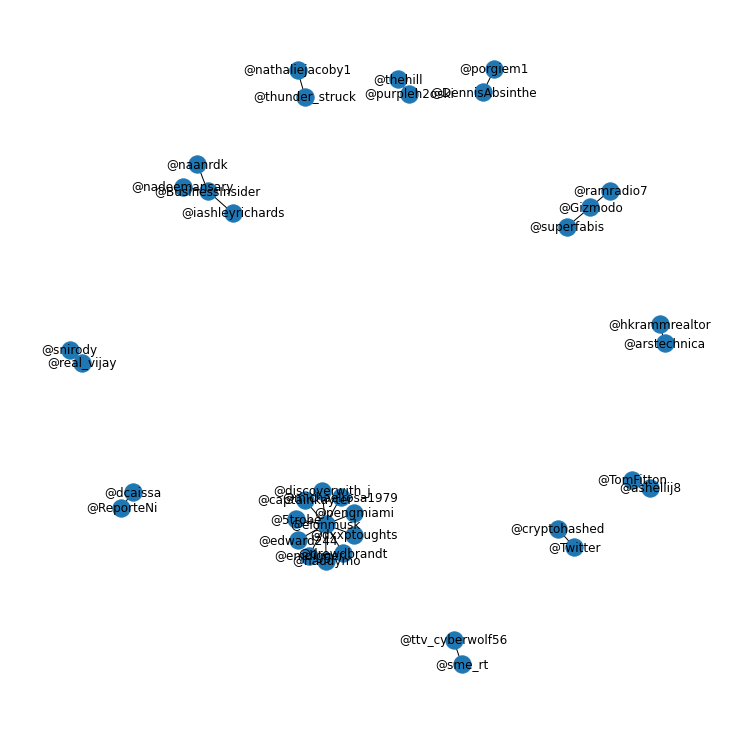

In [134]:
G1=islands[3][1]

plt.figure(figsize=(10,10))
#colors = ["green" if i[weight] > 0  else "red" for i in G_retweet.nodes ]
pos = nx.spring_layout(G1, seed=648)  # Seed layout for reproducible node positions
nx.draw(G1, pos, with_labels=True) #node_color=colors)
plt.show()

Looking at the difference in positive vs. Negative networks we see more positivity spreading than negativity with fewer strongly negative to strongly negative. 